# Importing required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
import nltk
nltk.download('stopwords') 
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer 
from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop = set(stopwords.words ('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

import tensorflow_hub as hub
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
# Function to create corpus
def create_corpus(target):
    corpus = []
    for x in tweet[tweet['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

# Bigram analysis
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Data cleaning functions
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (105)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251" "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)


def embed_text_data(df, hub_layer):
    train_examples = df['text']
    train_labels = df['target']
    embedded_data = hub_layer(train_examples)

    columns = [f"embedding_{i + 1}" for i in range(embedded_data.shape[1])]
    X_df = pd.DataFrame(data=embedded_data.numpy(), columns=columns)

    return X_df, train_labels

# Evaluate models
def evaluate_model(y_true, predictions, model_name):
    conf_matrix = confusion_matrix(y_true, predictions)
    classification_rep = classification_report(y_true, predictions)

    print(f"{model_name} Confusion Matrix:")
    print(conf_matrix)
    print(f"\n{model_name} Classification Report:")
    print(classification_rep)

    return conf_matrix, classification_rep


# Prediction function for a new tweet
def predict_tweet_class(new_tweet, hub_layer, model):
    new_tweet_embedding = hub_layer([new_tweet])[0].numpy()
    new_tweet_embedding = new_tweet_embedding.reshape(1, -1)
    predicted_class = model.predict(new_tweet_embedding)[0]
    return predicted_class



# Load data

In [41]:
path = 'C:/Users/HP/Desktop/Work/Learning/Machine Learning_30DayChallenge/3. Projects/Text_classification/'
tweet= pd.read_csv(path+'data/train.csv')
test=pd.read_csv(path+'data/test.csv')
tweet.head(3)
print('There are {} rows and {} columns in train'.format(tweet.shape[0], tweet.shape[1])) 
print('There are {} rows and {} columns in train'.format(test.shape[0], test.shape[1]))


There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


# Class distribution 

Text(0, 0.5, 'samples')

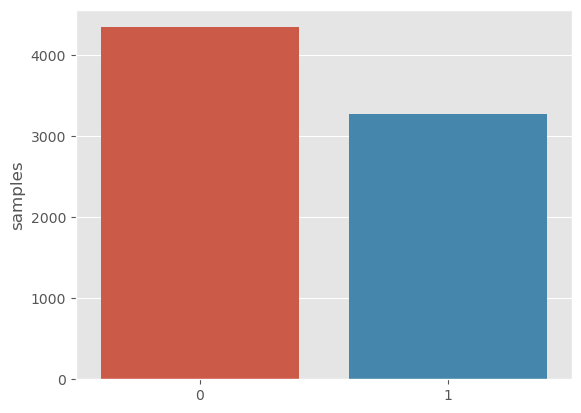

In [42]:
x = tweet.target.value_counts()
sns.barplot(x=x.index, y=x) 
plt.gca().set_ylabel('samples')

# Exploratory data analysis

### Number of characters in tweets

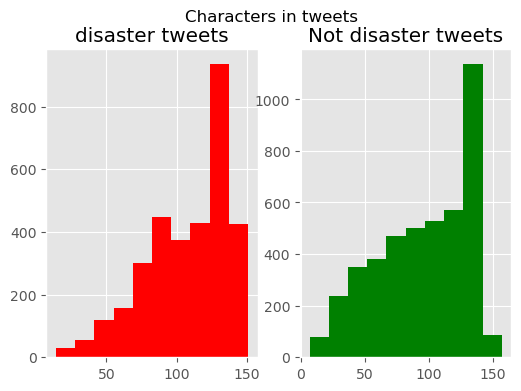

In [43]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,4)) 
tweet_len = tweet[tweet['target']==1]['text'].str.len() 
ax1.hist(tweet_len, color='red')
ax1.set_title('disaster tweets')
tweet_len = tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len, color='green') 
ax2.set_title('Not disaster tweets') 
fig.suptitle('Characters in tweets')
plt.show()


The distribution of both seems to be almost same.120 to 140 characters in a tweet are the most common among both.


### Number of words in a tweet

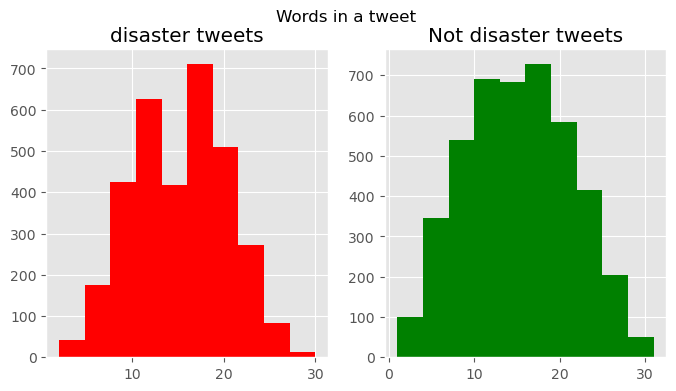

In [44]:
fig, (ax1, ax2)=plt.subplots(1,2, figsize=(8,4))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len, color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()


### Average word length in a tweet

Text(0.5, 0.98, 'Average word length in each tweet')

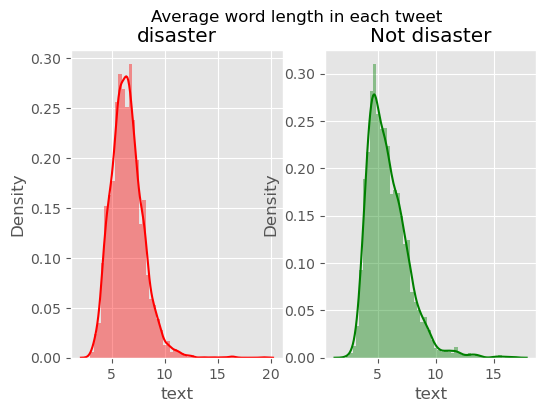

In [45]:

fig, (ax1, ax2)=plt.subplots(1,2, figsize=(6,4))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=tweet[tweet ['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x]) 
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2, color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')


### Common stopwords in tweets

<BarContainer object of 10 artists>

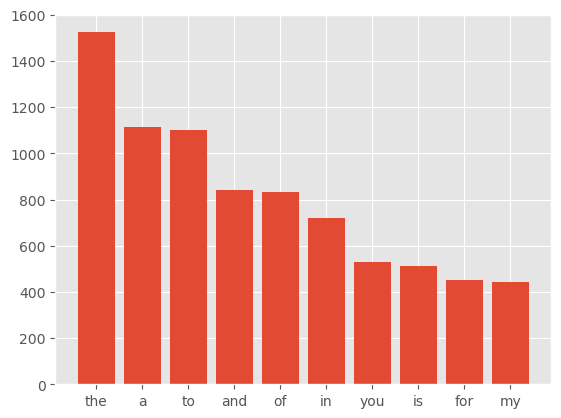

In [46]:
# First we will analyze tweets with class 0.
corpus= create_corpus(0)
dic=defaultdict(int)
for word in corpus:
    if word in stop: 
        dic [word] +=1
        top=sorted(dic.items(), key=lambda x:x[1], reverse=True) [:10]

x,y = zip(*top)
plt.bar(x,y)


<BarContainer object of 10 artists>

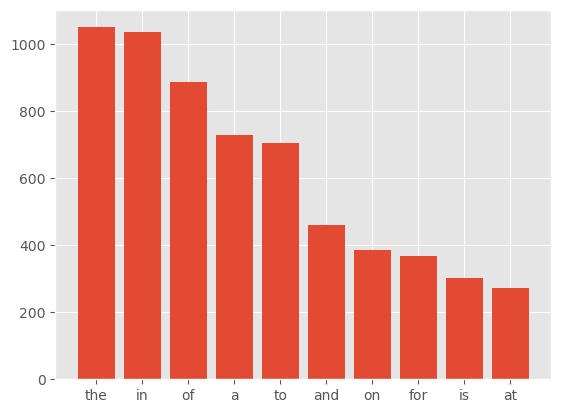

In [47]:
                               
# First we will analyze tweets with class 0.
corpus=create_corpus(1)
dic=defaultdict(int)
for word in corpus:
    if word in stop: 
        dic [word] +=1
        top=sorted(dic.items(), key=lambda x:x[1], reverse=True) [:10]

x,y = zip(*top)
plt.bar(x,y)


### Analyzing punctuations

<BarContainer object of 18 artists>

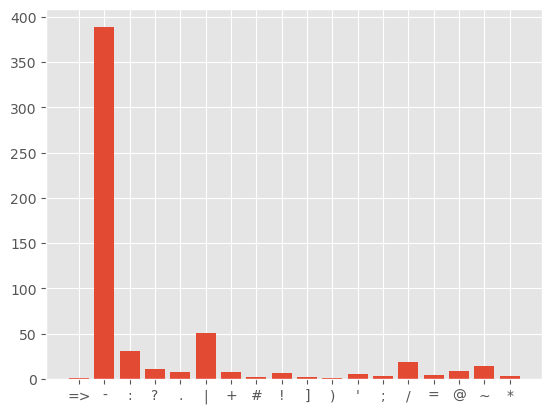

In [48]:
# First let's check tweets indicating real disaster.
# plt.figure(figsize=(6,4)) 
corpus=create_corpus (1)
dic=defaultdict(int) 
import string
special = string.punctuation 
for i in (corpus):
    if i in special: 
        dic[i] +=1
x,y=zip(*dic.items()) 
plt.bar(x,y)


<BarContainer object of 20 artists>

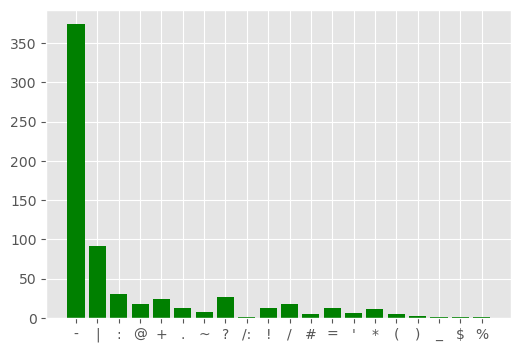

In [49]:
# Now,we will move on to class 0.
plt.figure(figsize=(6,4)) 
corpus=create_corpus (0)
dic=defaultdict(int) 
import string
special = string.punctuation 
for i in (corpus):
    if i in special:
        dic[i] +=1
x,y=zip(*dic.items()) 
plt.bar(x,y,color='green')


### Common words?

<AxesSubplot:>

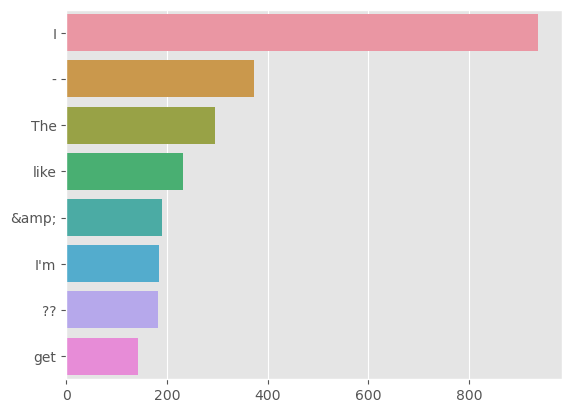

In [50]:

counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word, count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
sns.barplot(x=y, y=x)


### Ngram analysis

<AxesSubplot:>

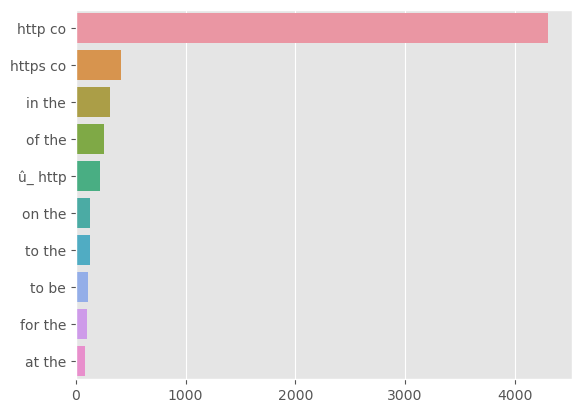

In [51]:

# we will do a bigram (n=2) analysis over the tweets. Let's check the most common bigrams in tweets.
def get_top_tweet_bigrams (corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words [0, idx]) for word, idx in vec.vocabulary_.items()] 
    words_freq =sorted (words_freq, key = lambda x: x[1], reverse=True)
    return words_freq [:n]
                               
# plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet ['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y, y=x)


# Data cleaning

In [52]:
df = tweet
df.shape

(7613, 5)

### Removing urls

In [53]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+') 
    return url.sub(r'',text)
df['text']=df['text'].apply(lambda x : remove_URL(x))


### Removing HTML tags

In [54]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)
df['text']=df['text'].apply(lambda x : remove_html(x))


### Removing Emojis

In [55]:
def remove_emoji(text):
    emoji_pattern= re.compile(" ["
                              u"\U0001F600-\U0001F64F" # emoticons
                              u"\U0001F300-\U0001F5FF" # symbols & pictographs u"\U0001F680-\U0001F6FF" # transport & map symbols u"\U0001F1E0-\U0001F1FF" # flags (105)
                              u"\U00002702-\U000027B0"
                              u"\U000024C2-\U0001F251" "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['text']=df['text'].apply(lambda x: remove_emoji(x))


### Removing punctuations

In [56]:
def remove_punct(text):
    table = str.maketrans('','', string.punctuation)
    return text.translate(table)
df['text'] = df['text'].apply(lambda x : remove_punct(x))
               


### Spelling Correction 

use pyspellchecker

In [57]:
df_train = df[['text', 'target']]
df_train.head()

,text,target
0,Our Deeds are the Reason of this earthquake Ma...,1
1,Forest fire near La Ronge Sask Canada,1
2,All residents asked to shelter in place are be...,1
3,13000 people receive wildfires evacuation orde...,1
4,Just got sent this photo from Ruby Alaska as s...,1


# Embedding 

### Download tfhub model

In [58]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
X_df, y = embed_text_data(df_train, hub_layer)

# Trainig models

In [59]:
# Assuming 'labels' are your target labels
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

In [60]:
# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=40)
rf_model.fit(X_df, y)
# Train a logistic regression model
lr_model = LogisticRegression(random_state=40)
lr_model.fit(X_train, y_train)
# Train an XGBoost model
xgb_model = XGBClassifier(n_estimators=100, random_state=40)
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=40, ...)

# Evaluate the models 

In [61]:
# Make predictions
rf_predictions = rf_model.predict(X_test)
# Make predictions
lr_predictions = lr_model.predict(X_test)
# Make predictions
xgb_predictions = xgb_model.predict(X_test)

In [62]:
rf_conf_matrix, rf_classification_report = evaluate_model(y_test, rf_predictions, "Random Forest")
print('==================================')
lr_conf_matrix, lr_classification_report = evaluate_model(y_test, lr_predictions, "Logistic Regression")
print('==================================')
xgb_conf_matrix, xgb_classification_report = evaluate_model(y_test, xgb_predictions, "XGBoost")


Random Forest Confusion Matrix:
[[869   5]
 [ 17 632]]

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       874
           1       0.99      0.97      0.98       649

    accuracy                           0.99      1523
   macro avg       0.99      0.98      0.99      1523
weighted avg       0.99      0.99      0.99      1523

Logistic Regression Confusion Matrix:
[[751 123]
 [194 455]]

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.83       874
           1       0.79      0.70      0.74       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523

XGBoost Confusion Matrix:
[[741 133]
 [205 444]]

XGBoost Classification Report:
              precision    recall  f1-score   support

           0

# Predict

In [38]:
# new_tweet = "Just finished reading an amazing book! 📚 Highly recommend it to anyone looking for a captivating story. The characters are so well-developed, and the plot twists kept me hooked until the very end. #BookRecommendation #ReadingCommunity"
new_tweet = '🚨 Emergency alert! A massive earthquake just struck the city.'
predicted_class = predict_tweet_class(new_tweet, hub_layer, rf_model)
print("Predicted Class:", predicted_class)

Predicted Class: 1


# Making our submission

In [ ]:
sample_sub = pd.read_csv('./data/sample_submission.csv')
y_pre=model.predict(final_test)
y_pre=np.round(y_pre).astype (int).reshape(3263)
sub = pd.DataFrame({'id':sample_sub['id'].values.tolist(), 'target':y_pre})
sub.to_csv('submission.csv', index=False)
sub.head()